In [2]:
# %pip install torch pymystem3 matplotlib

In [3]:
import torch
import torch.nn as nn
import re
from pymystem3 import Mystem
import matplotlib.pyplot as plt
# from collections import Counter

In [2]:
device = torch.device("cpu")
print(f"Using device: {device}")

epochs = 10

Using device: cpu


In [3]:
text = open("The_Fellowship_Of_The_Ring.txt","r").read()
text = text.replace("\n"," ")
text = re.sub(r'[^a-z@# ]', '', text.lower())
text = re.sub('[0-9]',' ', text)
text = text.lower()

m = Mystem()
text = m.lemmatize(text)
text = ''.join(text)

sentences = text.split('.')
window_size = 2

word_dict = []
words = []

for sentence in sentences:
    if len(sentence) >= window_size * 2 + 1:
        spl = re.sub(r'\W+',' ',sentence)
        spl = spl.split()
        words.append(spl)
        for s in spl:
            word_dict.append(s)
        
word_dict = set(word_dict)
word_dict = {word: i for i, word in enumerate(word_dict)}
bacov = dict(zip(word_dict.values(), word_dict.keys()))
len(word_dict)

8695

In [6]:
def train_model (model, optimizer, criterion, train_data):
    losses = []
    for epoch in range(epochs):
        cnt = 0
        loss_epoch = 0

        for pair in train_data:
            optimizer.zero_grad()
            output = model.forward(pair[1].to(device))

            loss = criterion(output,pair[0].to(device))
            loss.backward()

            optimizer.step()
            loss_epoch += loss.item()
            cnt += 1

        loss_epoch /= cnt
        losses.append(loss_epoch)
        print(f'Epoch {epoch+1}/{epochs}: Loss train = {loss_epoch}') 
    return losses

In [7]:
def plot_losses (arr):
    plt.figure()
    plt.plot(arr)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [8]:
def summarize(word1, word2, dict):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    UK_RF_148 = dict[word1] + dict[word2]
    mindist = 1000000000
    cnt = 0
    for word in dict.keys():
        if cos(dict[word],UK_RF_148) < mindist:
            mindist = cos(dict[word],UK_RF_148)
            mini = word
        cnt+=1
    return mini

In [9]:
def get_closest(vec, dict):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    mindist = 1000000000
    for word in dict.keys():
        if cos(dict[word],vec) < mindist:
            mindist = cos(dict[word],vec)
            mini = word
    return mini

In [10]:
dataset = []

for sentence in words:
    for i in range(window_size,len(sentence)-window_size):
        target = torch.zeros(len(word_dict))
        target[word_dict[sentence[i]]] = 1
        target = target.type(torch.LongTensor)
        context = []
        for j in range(i-window_size,i+window_size+1):
            if j == i:
                continue
            context.append(word_dict[sentence[j]])
        context = torch.tensor(context)
        dataset.append((target,context))


pivot = int(0.8*len(dataset))
train = dataset[:pivot]
test = dataset[pivot:]

pivot = int(0.05*len(dataset))
validation = test[:pivot]
test = test[pivot:]

In [11]:
class Word2VecCBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecCBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.LogSoftmax(dim=0)

    def forward(self, center_word_idx):
        hidden_layer = torch.mean(self.embeddings(center_word_idx), dim=1)
        out_layer = self.out_layer(hidden_layer)
        log_probs = self.activation_function(out_layer)
        return log_probs

In [12]:
w2v_cbow = Word2VecCBOWModel(len(word_dict),window_size*2).to(device)
criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.SGD(w2v_cbow.parameters(), lr=0.001)

Epoch 1/10: Loss train = 0.35550417967453046
Epoch 2/10: Loss train = 0.004947220733157773
Epoch 3/10: Loss train = 0.0028077761286342284
Epoch 4/10: Loss train = 0.001967741609593031
Epoch 5/10: Loss train = 0.001520483305065574
Epoch 6/10: Loss train = 0.0012435316890116368
Epoch 7/10: Loss train = 0.0010497834875248938
Epoch 8/10: Loss train = 0.0009201729167089275
Epoch 9/10: Loss train = 0.0008384779262153468
Epoch 10/10: Loss train = 0.0007827394834156699


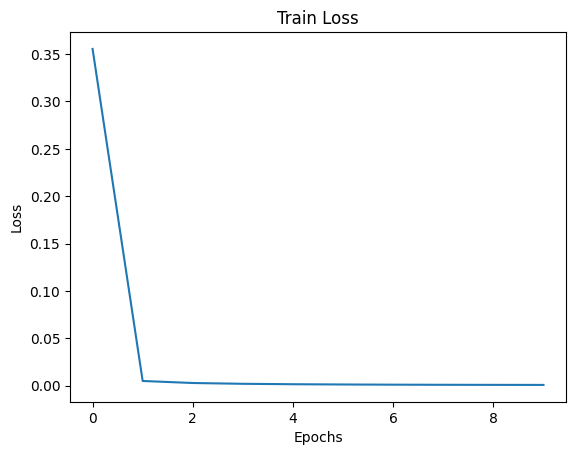

In [13]:
loss_arr = train_model (w2v_cbow, optimizer, criterion, train)

plot_losses (loss_arr)

In [14]:
out = w2v_cbow.forward(train[0][1].to(device))

embeddings = w2v_cbow.embeddings.weight.data.cpu()
w2v_dict = {bacov[ix]: embeddings[ix] for ix in range(len(word_dict))}

w2v_dict.keys()

dict_keys(['tintall', 'should', 'promising', 'handicrafts', 'bald', 'noro', 'suspicious', 'curtains', 'whoa', 'sails', 'poised', 'shirriffs', 'rippling', 'forthcoming', 'wraith', 'barns', 'curled', 'sent', 'rmil', 'frugal', 'finished', 'prowling', 'versions', 'hunting', 'typed', 'stepped', 'rewarded', 'straining', 'lifts', 'veils', 'rockets', 'popular', 'terribly', 'fulfilling', 'portended', 'closely', 'tighten', 'invitation', 'forgetfulness', 'tolerant', 'styled', 'luggage', 'waving', 'unceasingly', 'dimrill', 'restlessness', 'corrupts', 'testing', 'miss', 'burdened', 'their', 'food', 'loomed', 'cake', 'imitated', 'plant', 'gatekeepers', 'uplifted', 'witted', 'streamed', 'hatred', 'asking', 'cloths', 'friends', 'tall', 'past', 'fist', 'muttering', 'things', 'beardless', 'encouraging', 'fortress', 'lance', 'fulness', 'variations', 'fate', 'observations', 'chase', 'isn', 'yourself', 'hemmed', 'stoors', 'agricultural', 'astounding', 'dnadan', 'bushes', 'sixth', 'vardo', 'something', 'gif

In [15]:
print (summarize ('beauty', 'change', w2v_dict),
       summarize ('beautiful', 'colour', w2v_dict), 
       summarize ('till', 'never', w2v_dict),
       summarize ('really', 'shines', w2v_dict),
       summarize ('anxiety', 'judge', w2v_dict),
       get_closest (w2v_dict['back'] + w2v_dict['vanish'] - w2v_dict['beauty'], w2v_dict),
       sep='\n')

politely
danced
stooped
paved
lifted
despair


In [ ]:
device = torch.device("cuda")
print(f"Using device: {device}")

Using device: cuda


In [9]:
dataset2 = []

for sentence in words:
    for i in range(window_size,len(sentence)-window_size):
        target = torch.tensor(word_dict[sentence[i]])
        context = torch.zeros(len(word_dict))

        for j in range(i-window_size,i+window_size+1):
            if j == i:
                continue
            context[word_dict[sentence[j]]] = 1

        context = context.type(torch.LongTensor)
        dataset2.append((target,context))

pivot = int(0.8*len(dataset2))
train = dataset2[:pivot]
test = dataset2[pivot:]

pivot = int(0.05*len(dataset2))
validation = test[:pivot]
test = test[pivot:]

In [18]:
class Word2VecSkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecSkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.LogSoftmax(dim=-1)

    def forward(self, center_word_idx):
        hidden_layer = self.embeddings(center_word_idx)
        out_layer = self.out_layer(hidden_layer)
        log_probs = self.activation_function(out_layer)
        return log_probs

In [22]:
w2v_SGM = Word2VecSkipGramModel(len(word_dict),4).to(device)
criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.SGD(w2v_SGM.parameters(), lr=0.05)

Epoch 1/10: Loss train = 0.008465239544229808
Epoch 2/10: Loss train = 0.0015374904626801707
Epoch 3/10: Loss train = 0.001449727964902088
Epoch 4/10: Loss train = 0.0013655817538111641
Epoch 5/10: Loss train = 0.0012696965545140125
Epoch 6/10: Loss train = 0.0011586291661892618
Epoch 7/10: Loss train = 0.0010482984341780232
Epoch 8/10: Loss train = 0.0009522828647321706
Epoch 9/10: Loss train = 0.0008670478919548082
Epoch 10/10: Loss train = 0.0007965948934004113


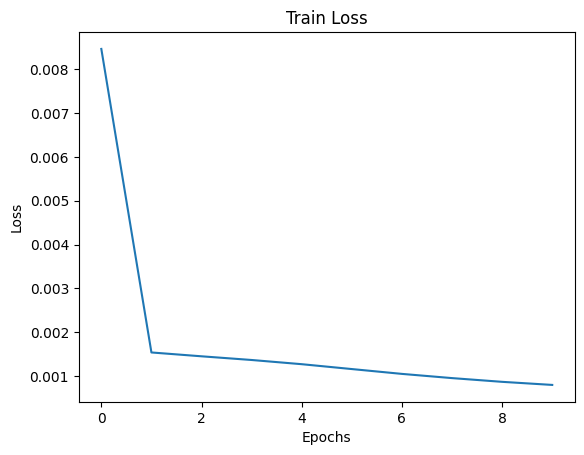

In [25]:
loss_arr = train_model (w2v_SGM, optimizer, criterion, train)

plot_losses (loss_arr)

In [26]:
embeddings2 = w2v_SGM.embeddings.weight.data.cpu()
w2v_dict2 = {bacov[ix]: embeddings2[ix] for ix in range(len(word_dict))}

w2v_dict2.keys()

dict_keys(['hurled', 'family', 'band', 'hive', 'stricken', 'sputtered', 'money', 'baranduin', 'lawn', 'uneasily', 'nearer', 'affairs', 'moot', 'elladan', 'buckland', 'amroth', 'splintered', 'pronouncement', 'eerie', 'vagabonds', 'clutch', 'picking', 'wanes', 'jutting', 'fastened', 'dizzy', 'briar', 'haunted', 'gimbatul', 'circle', 'stream', 'bundle', 'sees', 'owners', 'charred', 'decent', 'shunned', 'uncovering', 'grieve', 'stick', 'looming', 'beautiful', 'look', 'marked', 'stand', 'crushing', 'pleasantly', 'purchase', 'briefly', 'waking', 'curious', 'accorded', 'tharbad', 'dwelling', 'steered', 'valinor', 'finally', 'touches', 'flames', 'shift', 'shortcomings', 'silently', 'lyin', 'moor', 'disturber', 'pierce', 'thrawn', 'wary', 'prices', 'suspiciously', 'warming', 'ropes', 'guesses', 'does', 'oh', 'redoubled', 'rob', 'confess', 'heath', 'hemlocks', 'please', 'hi', 'mantle', 'supported', 'ridge', 'peoples', 'hoard', 'try', 'doubled', 'rich', 'mined', 'singular', 'nuisances', 'darkling

In [17]:
print (summarize ('beauty', 'change', w2v_dict2),
       summarize ('beautiful', 'colour', w2v_dict2), 
       summarize ('till', 'never', w2v_dict2),
       summarize ('really', 'shines', w2v_dict2),
       summarize ('anxiety', 'judge', w2v_dict2),
       get_closest (w2v_dict2['back'] + w2v_dict2['vanish'], w2v_dict2),
       sep='\n')

NameError: name 'w2v_dict2' is not defined